In [30]:
import torch

### Load Analyzed Games

In [31]:
dataset = torch.load("datasets/all_games_analyzed.pt")

In [32]:
# dataset is of the form [(white_analysis, black_analysis), (white_elo, black_elo)]
print(f"Number of games: {len(dataset)}")
print(f"Moves of first game: {len(dataset[0][0][0])}")
print(f"Input size: {len(dataset[0][0][0][0])}")

input_size = len(dataset[0][0][0][0])

Number of games: 2000
Moves of first game: 14
Input size: 771


### Define the Model

In [33]:
from lstm_netwrok import initialize_model

In [34]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    device = torch.device("cuda")          # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu") 

Using GPU: NVIDIA GeForce MX230


In [35]:
hidden_size = 128
num_layers = 2
lstm_model, optimizer = initialize_model(input_size, hidden_size, num_layers, device)

### Modify the dataset for training

In [36]:
import random

total_games = len(dataset)
# Define maximum elo in the dataset for normalization
max_elo = 3000
# max_elo = max([max(game[1]) for game in dataset])

# Spilt into train and test data
test_games = int(total_games * 0.15)

random.shuffle(dataset)

# Also batch together black and white analysis for each game
x_train = [torch.stack(game[0]).to(device) for game in dataset[:-test_games]]
y_train = [torch.tensor(game[1]).float().reshape((2, 1)).to(device)/max_elo for game in dataset[:-test_games]]

x_test =  [torch.stack(game[0]).to(device) for game in dataset[-test_games:]]
y_test =  [torch.tensor(game[1]).float().reshape((2, 1)).to(device)/max_elo for game in dataset[-test_games:]]

### Train the model

In [37]:
from lstm_netwrok import train_model

In [38]:
# MSE loss for single output prediction
loss_func = torch.nn.functional.mse_loss

loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=10)

Epoch: 1, Validation Loss: 0.03358855346566498
Epoch: 2, Validation Loss: 0.03542830093931258
Epoch: 3, Validation Loss: 0.02962198752802757
Epoch: 4, Validation Loss: 0.025643248142125017
Epoch: 5, Validation Loss: 0.02660174961129087
Epoch: 6, Validation Loss: 0.02587602866751338
Epoch: 7, Validation Loss: 0.026614633904276108
Epoch: 8, Validation Loss: 0.025036501031782416
Epoch: 9, Validation Loss: 0.02404109207085033
Epoch: 10, Validation Loss: 0.02684539639160671


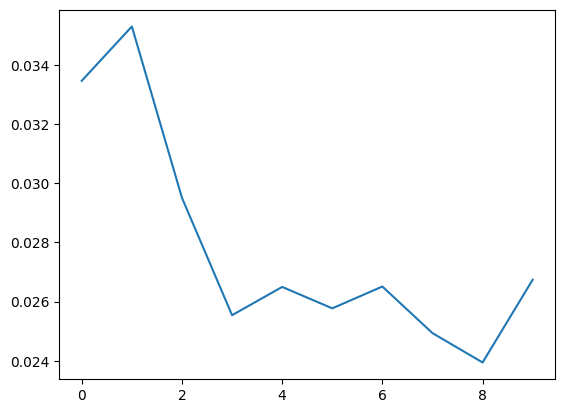

In [40]:
import matplotlib.pyplot as plt

# Visualize the loss as the network trained
# Should be a downward trend
plt.plot(loss_graph)

### Test how the model predicts new data

The predictions of the model are compared to a random guessing and a constant guessing model


In [66]:
predictions = []
real_values = []

for x, y in zip(x_test, y_test):
    # Predict for white and black
    out = lstm_model.forward(x[0], train=False)[0] # [0] to get rid of hidden states
    predictions.append(out[0].item() * max_elo)
    real_values.append(y[0].item() * max_elo)

    out = lstm_model.forward(x[1], train=False)[0]
    
    predictions.append(out[0].item() * max_elo) # [0].item() to get rid of batch dimension and get the elo prediction
    real_values.append(y[1].item() * max_elo)

In [75]:
def rate_predictions(predictions, real_values):
    correct = 0
    # We give the model a leeway of +-200 points
    # More leeway = more accuracy
    leeway = 200
    for prediction, real in zip(predictions, real_values):
        if real - leeway <= prediction <= real + leeway:
            correct += 1
    return correct / len(predictions), correct

percentage, correct = rate_predictions(predictions, real_values)
print(f"Correctly predicted {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(predictions)} predictions")

Correctly predicted 30.50% of games
183 out of 600 predictions


In [71]:
import random

random_predictions = [random.randint(800, 3000) for _ in range(len(predictions))]
percentage, correct = rate_predictions(random_predictions, real_values)
print(f"Correctly guessed at random {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(random_predictions)} predictions")   

Correctly guessed at random 9.50% of games
57 out of 600 predictions


In [73]:
constant_predictions = [(800 + 2800)//2 for _ in range(len(predictions))]
percentage, correct = rate_predictions(constant_predictions, real_values)
print(f"Correctly guessed with constant guess {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(constant_predictions)} predictions")   

Correctly guessed with constant guess 10.33% of games
62 out of 600 predictions


In [50]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), "models/lstm_model_single_output.pt")